In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# FINANCIAL MODELS: CODE WALKTHROUGH


## 1. Overview of the Base Model

The `BaseModel` class provides foundational methods used by all financial models:
- **Black-Scholes pricing formula**: The cornerstone of option pricing
- **Implied volatility calculation**: Extracting market expectations from prices

This class serves as a parent for specialized models (BSHW, Heston-HW, SZHW).

### Black-Scholes Option Pricing Formula


In [4]:
def BS_example():
    """
    Black-Scholes formula computes European option prices:
    
    Call: C = S₀N(d₁) - Ke^(-rτ)N(d₂)
    Put:  P = Ke^(-rτ)N(-d₂) - S₀N(-d₁)
    
    where:
        d₁ = [ln(S₀/K) + (r + σ²/2)τ] / (σ√τ)
        d₂ = d₁ - σ√τ
    
    Key parameters:
    - S₀: Current stock price
    - K: Strike price
    - r: Risk-free rate
    - σ: Volatility
    - τ: Time to maturity
    """
    S_0, K, r, sigma, tau = 100, 100, 0.05, 0.2, 1.0
    
    d1 = (np.log(S_0/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    
    call = S_0 * stats.norm.cdf(d1) - K * np.exp(-r*tau) * stats.norm.cdf(d2)
    put = K * np.exp(-r*tau) * stats.norm.cdf(-d2) - S_0 * stats.norm.cdf(-d1)
    
    print(f"Example: S₀=${S_0}, K=${K}, σ={sigma}, τ={tau}yr")
    print(f"  d₁ = {d1:.4f}, d₂ = {d2:.4f}")
    print(f"  Call Price = ${call:.2f}")
    print(f"  Put Price  = ${put:.2f}")

BS_example()

# Code section: Implied Volatility
print("\n### Implied Volatility Calculation\n")

"""
The `ImpliedVolatilityBlack76` method inverts the Black-Scholes formula:

**Goal:** Find σ such that BS_Price(σ) = Market_Price

**Method:** Newton-Raphson iteration
    σₙ₊₁ = σₙ - f(σₙ)/f'(σₙ)
    where f(σ) = BS_Price(σ) - Market_Price

**Robustness:** Falls back to binary search if Newton-Raphson fails

**Bounds:** Volatility is constrained to [0.001, 2.0] for numerical stability
"""

print("Newton-Raphson: Iteratively solve BS_Price(σ) = Market_Price")
print("Fallback: Binary search between [0.001, 2.0] if iteration fails")


Example: S₀=$100, K=$100, σ=0.2, τ=1.0yr
  d₁ = 0.3500, d₂ = 0.1500
  Call Price = $10.45
  Put Price  = $5.57

### Implied Volatility Calculation

Newton-Raphson: Iteratively solve BS_Price(σ) = Market_Price
Fallback: Binary search between [0.001, 2.0] if iteration fails


## 2. The BSHW Model: Stochastic Interest Rates

The BSHW model extends Black-Scholes by making interest rates stochastic:

**Stock dynamics:**
    dS/S = r(t) dt + σ dWₛ

**Interest rate dynamics (Hull-White):**
    dr(t) = [θ(t) - λr(t)]dt + η dWᵣ
    
where:
- λ: Mean reversion speed
- η: Interest rate volatility
- θ(t): Time-dependent drift (calibrated to yield curve)
- Correlation: dWₛ · dWᵣ = ρ dt

**Key Innovation:** The composite volatility formula accounts for rate uncertainty.

### BSHW Composite Volatility


The `BSHWVolatility` function computes the adjusted volatility:

**Formula:**
    σ_C² = (1/T) ∫₀ᵀ σ_F²(t,T) dt

where the forward volatility is:
    σ_F²(t,T) = σ² + η²Bᵣ²(t,T) - 2ρσηBᵣ(t,T)

and Bᵣ(t,T) is the Hull-White factor:
    Bᵣ(t,T) = (1/λ)[e^(-λ(T-t)) - 1]

**Numerical Integration:**
- Grid: 1000 points from 0 to T
- Method: Trapezoidal rule via integrate.trapz
- Safety: Ensures sqrt argument is non-negative

**Fallback:** If integration fails, uses approximation:
    σ_C ≈ √(σ² + 0.5(η/λ)²)

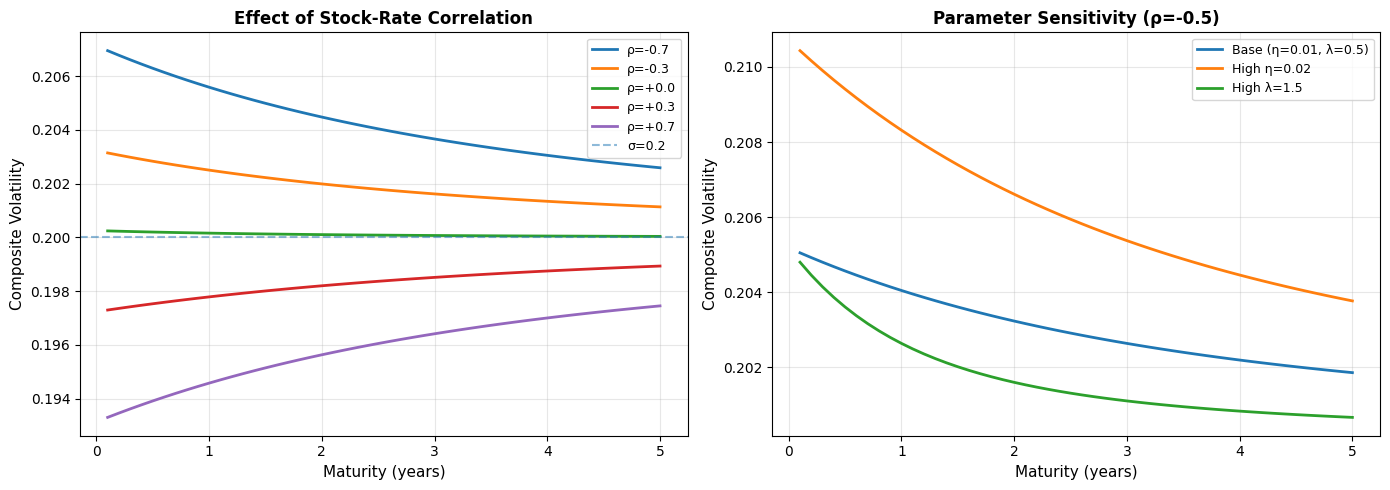


**Key Insights:**
  • Negative ρ: Stock and rates move opposite → Higher volatility
  • Positive ρ: Stock and rates aligned → Lower volatility
  • Higher η: More rate uncertainty → Higher composite volatility
  • Higher λ: Faster mean reversion → Less rate impact on long maturities


In [5]:
def visualize_bshw_volatility():
    """Visualize how correlation affects composite volatility"""
    T_vals = np.linspace(0.1, 5, 50)
    sigma = 0.20
    eta = 0.01
    lambd = 0.5
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left plot: Correlation effect
    for rho in [-0.7, -0.3, 0.0, 0.3, 0.7]:
        vols = []
        for T in T_vals:
            B_r = (1 - np.exp(-lambd*T)) / (lambd*T)
            vol_sq = sigma**2 + (eta*B_r)**2 - 2*rho*sigma*eta*B_r
            vols.append(np.sqrt(max(vol_sq, 0.001)))
        ax1.plot(T_vals, vols, linewidth=2, label=f'ρ={rho:+.1f}')
    
    ax1.axhline(sigma, linestyle='--', alpha=0.5, label=f'σ={sigma}')
    ax1.set_xlabel('Maturity (years)', fontsize=11)
    ax1.set_ylabel('Composite Volatility', fontsize=11)
    ax1.set_title('Effect of Stock-Rate Correlation', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Parameter sensitivity
    rho = -0.5
    base_vols = []
    high_eta_vols = []
    high_lambd_vols = []
    
    for T in T_vals:
        # Base case
        B_r = (1 - np.exp(-lambd*T)) / (lambd*T)
        vol_sq = sigma**2 + (eta*B_r)**2 - 2*rho*sigma*eta*B_r
        base_vols.append(np.sqrt(max(vol_sq, 0.001)))
        
        # Higher rate volatility
        B_r = (1 - np.exp(-lambd*T)) / (lambd*T)
        vol_sq = sigma**2 + (0.02*B_r)**2 - 2*rho*sigma*0.02*B_r
        high_eta_vols.append(np.sqrt(max(vol_sq, 0.001)))
        
        # Higher mean reversion
        B_r = (1 - np.exp(-1.5*T)) / (1.5*T)
        vol_sq = sigma**2 + (eta*B_r)**2 - 2*rho*sigma*eta*B_r
        high_lambd_vols.append(np.sqrt(max(vol_sq, 0.001)))
    
    ax2.plot(T_vals, base_vols, linewidth=2, label='Base (η=0.01, λ=0.5)')
    ax2.plot(T_vals, high_eta_vols, linewidth=2, label='High η=0.02')
    ax2.plot(T_vals, high_lambd_vols, linewidth=2, label='High λ=1.5')
    ax2.set_xlabel('Maturity (years)', fontsize=11)
    ax2.set_ylabel('Composite Volatility', fontsize=11)
    ax2.set_title('Parameter Sensitivity (ρ=-0.5)', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_bshw_volatility()

print("\n**Key Insights:**")
print("  • Negative ρ: Stock and rates move opposite → Higher volatility")
print("  • Positive ρ: Stock and rates aligned → Lower volatility")
print("  • Higher η: More rate uncertainty → Higher composite volatility")
print("  • Higher λ: Faster mean reversion → Less rate impact on long maturities")


## 3. The CIR Process: Square-Root Diffusion

The Cox-Ingersoll-Ross process models variance/rates:

**SDE:**
    dv(t) = κ(v̄ - v(t))dt + γ√v(t) dW(t)

**Properties:**
- Mean reversion to v̄ with speed κ
- Square-root diffusion keeps v(t) > 0 (if Feller condition holds)
- Conditionally chi-square distributed

### 3.1. The `CIR_Sample` Method

This implements **exact sampling** (not Euler discretization):

**Exact Distribution:**
    v(t) ~ c · χ²(δ, κ̄)

where:
    δ = 4κv̄/γ²                            (degrees of freedom)
    κ̄ = 4κv(s)e^(-κ(t-s))/[γ²(1-e^(-κ(t-s)))]  (non-centrality parameter)
    c = γ²(1-e^(-κ(t-s)))/(4κ)             (scaling factor)

**Advantages over Euler:**
- Exact distribution between time points
- No discretization bias
- Better for long time steps
- Naturally stays positive

**Error Handling:**
- Ensures δ ≥ 0.1 and κ̄ ≥ 0 for valid chi-square parameters
- Falls back to Euler if sampling fails
- Applies floor at 1e-8 to ensure positive variance

**Implementation Note:**
The FIXED VERSION handles both scalar and array inputs for v_s,
processing each element individually for the noncentral chi-square distribution.

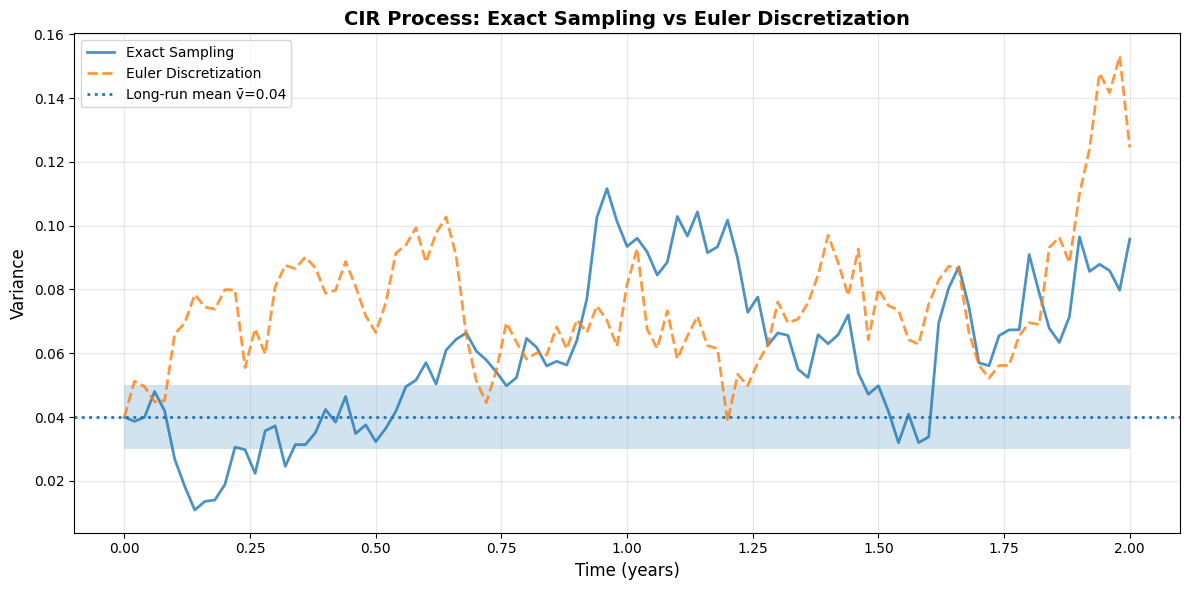


Comparison (κ=2.0, v̄=0.04, γ=0.3):
  Exact  - Mean: 0.0598, Std: 0.0241
  Euler  - Mean: 0.0751, Std: 0.0207
  Target - Mean: 0.0400

**Why Exact Sampling Matters:**
  ✓ No discretization bias
  ✓ Valid for large time steps
  ✓ Proper distribution between observations
  ✓ More accurate option pricing


In [6]:
def demonstrate_cir_sampling():
    """Compare CIR exact sampling vs Euler discretization"""
    np.random.seed(42)
    kappa = 2.0
    vbar = 0.04
    gamma = 0.3
    v0 = 0.04
    T = 2.0
    N = 100
    dt = T / N
    
    # Exact sampling (simplified for demo)
    v_exact = np.zeros(N+1)
    v_exact[0] = v0
    for i in range(N):
        delta = 4*kappa*vbar / gamma**2
        c = gamma**2 * (1 - np.exp(-kappa*dt)) / (4*kappa)
        kappaBar = 4*kappa*v_exact[i]*np.exp(-kappa*dt) / (gamma**2*(1-np.exp(-kappa*dt)))
        v_exact[i+1] = max(c * np.random.noncentral_chisquare(max(delta, 0.1), max(kappaBar, 0)), 1e-8)
    
    # Euler discretization
    v_euler = np.zeros(N+1)
    v_euler[0] = v0
    for i in range(N):
        dW = np.random.normal(0, np.sqrt(dt))
        v_euler[i+1] = v_euler[i] + kappa*(vbar - v_euler[i])*dt + gamma*np.sqrt(max(v_euler[i], 0))*dW
        v_euler[i+1] = max(v_euler[i+1], 0)
    
    time = np.linspace(0, T, N+1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(time, v_exact, linewidth=2, label='Exact Sampling', alpha=0.8)
    plt.plot(time, v_euler, '--', linewidth=2, label='Euler Discretization', alpha=0.8)
    plt.axhline(vbar, linestyle=':', linewidth=2, label=f'Long-run mean v̄={vbar}')
    plt.fill_between(time, vbar-0.01, vbar+0.01, alpha=0.2)
    plt.xlabel('Time (years)', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('CIR Process: Exact Sampling vs Euler Discretization', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nComparison (κ={kappa}, v̄={vbar}, γ={gamma}):")
    print(f"  Exact  - Mean: {np.mean(v_exact):.4f}, Std: {np.std(v_exact):.4f}")
    print(f"  Euler  - Mean: {np.mean(v_euler):.4f}, Std: {np.std(v_euler):.4f}")
    print(f"  Target - Mean: {vbar:.4f}")

demonstrate_cir_sampling()

print("\n**Why Exact Sampling Matters:**")
print("  ✓ No discretization bias")
print("  ✓ Valid for large time steps")
print("  ✓ Proper distribution between observations")
print("  ✓ More accurate option pricing")


## 4. The Heston-HW Model: Double Stochastic Framework

The Heston-Hull-White model combines:
- **Stochastic volatility** (Heston)
- **Stochastic interest rates** (Hull-White)

### 4.1. The System of SDEs

**Stock price:**
    dS/S = r(t) dt + √v(t) dWₛ

**Variance (CIR process):**
    dv(t) = κ(v̄ - v)dt + γ√v dWᵥ

**Interest rate (Hull-White):**
    dr(t) = [θ(t) - λr]dt + η dWᵣ

**Correlations:**
    dWₛ · dWᵥ = ρₓᵥ dt  (leverage effect)
    dWₛ · dWᵣ = ρₓᵣ dt  (stock-rate correlation)

### 4.2. The `GeneratePathsHestonHW_AES` Method

This implements **Almost Exact Simulation (AES)**:

**Key Steps:**

1. **Initialize arrays:** S, V, R for stock, variance, rate paths

2. **Generate correlated random numbers:**
   - Z₁ ~ N(0,1) for stock
   - Z₂ ~ N(0,1) auxiliary
   - Z₃ = ρₓᵣZ₁ + √(1-ρ²ₓᵣ)Z₂ for rate (correlated with stock)

3. **For each time step:**
   
   a) **Update variance (CIR exact sampling):**
      - Call CIR_Sample for each path individually
      - Uses exact chi-square distribution
      - No Euler approximation
   
   b) **Update interest rate (simplified HW):**
      - r_{i+1} = r_i + λ(r₀ - r_i)dt + η√dt·Z₃
      - Mean-reverting to initial rate
   
   c) **Update stock price (log-normal):**
      - drift = (r_i - 0.5v_i)dt
      - diffusion = √v_i·√dt·Z₁
      - S_{i+1} = S_i·exp(drift + diffusion)

4. **Calculate money market account:**
   - M(t) = exp(∫₀ᵗ r(s)ds)
   - Approximated as M(t) ≈ exp(Σ r_i·dt)
   - Used for discounting payoffs

**Error Handling:**
Falls back to geometric Brownian motion if path generation fails.

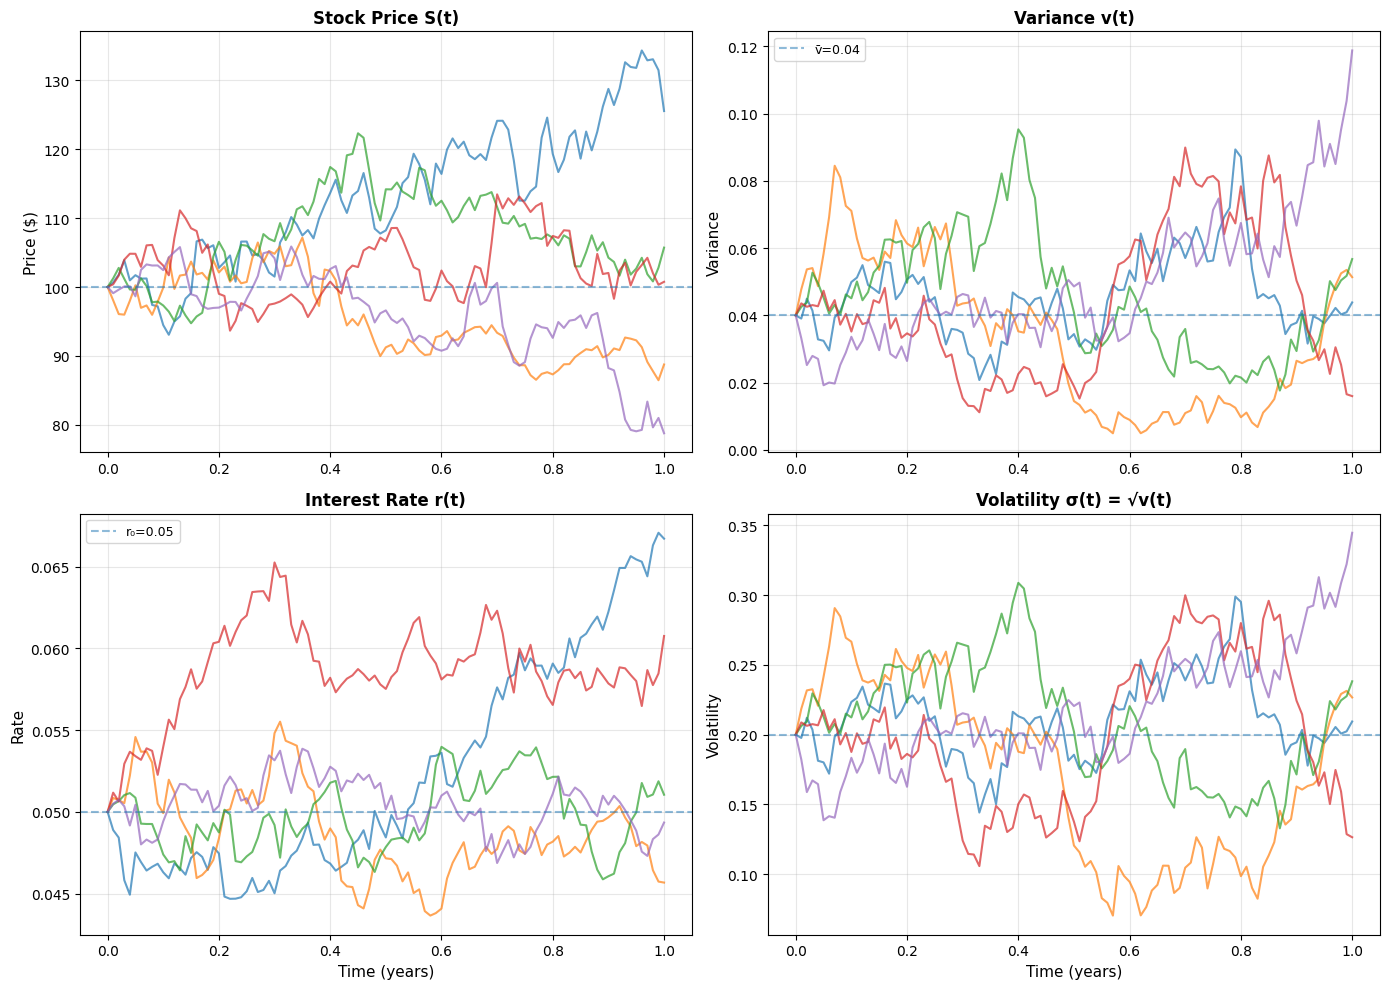


**Key Features of Heston-HW:**
  • Stochastic volatility → Volatility smile/skew
  • Stochastic rates → Term structure effects
  • Leverage effect (ρₓᵥ < 0) → Asymmetric smile
  • Path-dependent discounting via M(t)


In [7]:
def visualize_heston_hw_paths():
    """Visualize sample paths from Heston-HW model"""
    np.random.seed(42)
    S0, v0, r0 = 100, 0.04, 0.05
    kappa, vbar, gamma = 2.0, 0.04, 0.3
    lambd, eta = 0.5, 0.01
    T, N = 1.0, 100
    dt = T / N
    n_paths = 5
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for path_idx in range(n_paths):
        # Initialize
        S = np.zeros(N+1)
        V = np.zeros(N+1)
        R = np.zeros(N+1)
        S[0], V[0], R[0] = S0, v0, r0
        
        # Generate path
        for i in range(N):
            # Variance (simplified CIR)
            delta = 4*kappa*vbar / gamma**2
            c = gamma**2 * (1 - np.exp(-kappa*dt)) / (4*kappa)
            kappaBar = 4*kappa*V[i]*np.exp(-kappa*dt) / (gamma**2*(1-np.exp(-kappa*dt)))
            V[i+1] = max(c * np.random.noncentral_chisquare(max(delta, 0.1), max(kappaBar, 0)), 1e-8)
            
            # Rate
            R[i+1] = R[i] + lambd*(r0 - R[i])*dt + eta*np.sqrt(dt)*np.random.normal()
            
            # Stock
            Z = np.random.normal()
            drift = (R[i] - 0.5*V[i])*dt
            diffusion = np.sqrt(max(V[i], 1e-8))*np.sqrt(dt)*Z
            S[i+1] = S[i] * np.exp(drift + diffusion)
        
        time = np.linspace(0, T, N+1)
        axes[0,0].plot(time, S, linewidth=1.5, alpha=0.7)
        axes[0,1].plot(time, V, linewidth=1.5, alpha=0.7)
        axes[1,0].plot(time, R, linewidth=1.5, alpha=0.7)
        axes[1,1].plot(time, np.sqrt(V), linewidth=1.5, alpha=0.7)
    
    axes[0,0].set_title('Stock Price S(t)', fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Price ($)', fontsize=11)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].axhline(S0, linestyle='--', alpha=0.5)
    
    axes[0,1].set_title('Variance v(t)', fontsize=12, fontweight='bold')
    axes[0,1].set_ylabel('Variance', fontsize=11)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].axhline(vbar, linestyle='--', alpha=0.5, label=f'v̄={vbar}')
    axes[0,1].legend(fontsize=9)
    
    axes[1,0].set_title('Interest Rate r(t)', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Time (years)', fontsize=11)
    axes[1,0].set_ylabel('Rate', fontsize=11)
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axhline(r0, linestyle='--', alpha=0.5, label=f'r₀={r0}')
    axes[1,0].legend(fontsize=9)
    
    axes[1,1].set_title('Volatility σ(t) = √v(t)', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Time (years)', fontsize=11)
    axes[1,1].set_ylabel('Volatility', fontsize=11)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(np.sqrt(vbar), linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

visualize_heston_hw_paths()

print("\n**Key Features of Heston-HW:**")
print("  • Stochastic volatility → Volatility smile/skew")
print("  • Stochastic rates → Term structure effects")
print("  • Leverage effect (ρₓᵥ < 0) → Asymmetric smile")
print("  • Path-dependent discounting via M(t)")

## 5. Monte Carlo Pricing: 

The `EUOptionPriceFromMCPathsGeneralizedStochIR` Method

This method prices European options using simulated paths:

### 5.1. Algorithm

**Input:**
- CP: Option type (CALL or PUT)
- S: Terminal stock prices (N_paths × 1)
- K: Array of strike prices
- T: Maturity
- M: Money market account values M(T) for discounting

**Steps:**

1. **For each strike K_i:**
   
   a) Calculate payoffs for all paths:
      - Call: max(S - K_i, 0)
      - Put: max(K_i - S, 0)
   
   b) Discount each payoff by path-specific discount factor:
      - Discounted payoff = Payoff / M(T)
   
   c) Average across all paths:
      - Option price = (1/N) Σ [Payoff_j / M(T)_j]

2. **Return array of prices for all strikes**

### 5.2. Why Path-Dependent Discounting?

In models with stochastic rates:
- Each path has different interest rate evolution
- Money market account M(t) = exp(∫₀ᵗ r(s)ds) varies by path
- Correct discounting requires path-specific M(T)

**Contrast with constant rate:**
- Black-Scholes: Single discount factor e^(-rT)
- Stochastic rates: Each path has M(T)_j

### 5.3. Martingale Check

The code includes martingale tests:
    E[S(T)/M(T)] ≈ S(0)

If this ratio deviates significantly from 1.0, it indicates:
- Discretization bias
- Insufficient paths
- Numerical errors

A well-calibrated model should have this ratio ≈ 1.0

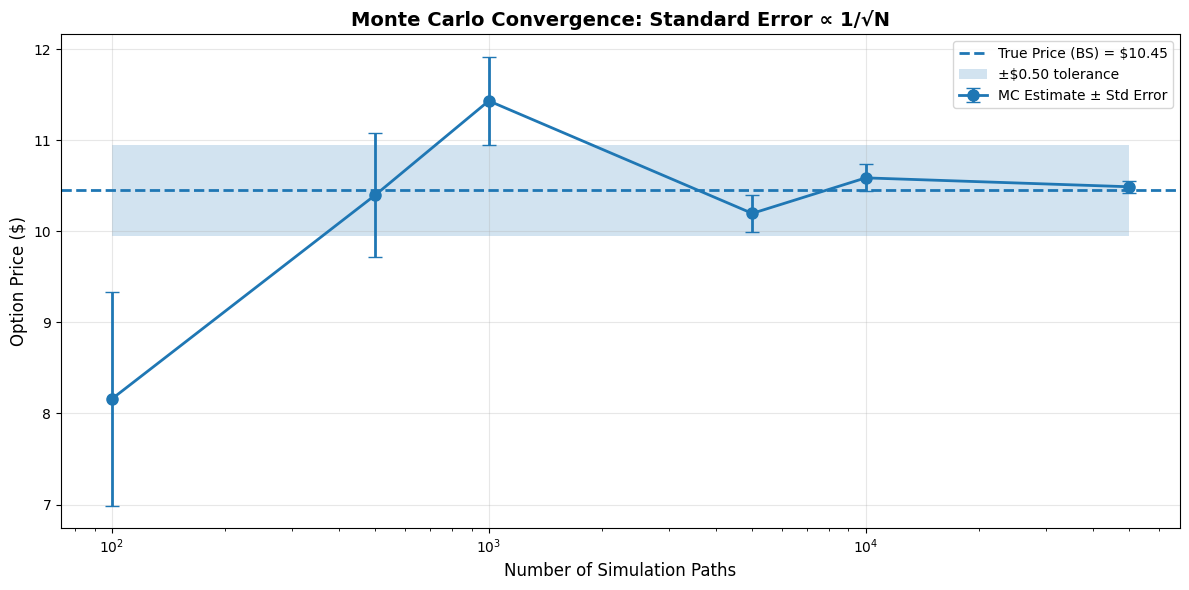


  Paths MC Price Std Error Error from True
   100  $8.1600   $1.1724         $2.2906
   500 $10.3996   $0.6809         $0.0509
  1000 $11.4332   $0.4841         $0.9826
  5000 $10.1974   $0.2060         $0.2532
 10000 $10.5875   $0.1489         $0.1369
 50000 $10.4898   $0.0657         $0.0392

**MC Pricing Key Points:**
  • Convergence: O(1/√N) regardless of dimension
  • Unbiased estimator (if discretization is fine enough)
  • Works for any payoff structure
  • Stochastic rates: Must use path-dependent discounting
  • Martingale test: Check E[S_T/M_T] ≈ S_0


In [8]:
def demonstrate_mc_pricing():
    """Demonstrate MC pricing with convergence"""
    np.random.seed(42)
    S0, K, r, sigma, T = 100, 100, 0.05, 0.2, 1.0
    
    # True Black-Scholes price
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    true_price = S0 * stats.norm.cdf(d1) - K * np.exp(-r*T) * stats.norm.cdf(d2)
    
    # MC simulation with different path counts
    path_counts = [100, 500, 1000, 5000, 10000, 50000]
    prices = []
    errors = []
    
    for n in path_counts:
        # Simulate terminal stock prices
        Z = np.random.normal(0, 1, n)
        S_T = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
        
        # Calculate payoffs
        payoffs = np.maximum(S_T - K, 0)
        
        # Discount (constant rate for this demo)
        M_T = np.exp(r * T)
        discounted_payoffs = payoffs / M_T
        
        # Price and standard error
        price = np.mean(discounted_payoffs)
        std_error = np.std(discounted_payoffs) / np.sqrt(n)
        
        prices.append(price)
        errors.append(std_error)
    
    # Plot convergence
    plt.figure(figsize=(12, 6))
    plt.errorbar(path_counts, prices, yerr=errors, fmt='o-', linewidth=2, 
                 markersize=8, capsize=5, label='MC Estimate ± Std Error')
    plt.axhline(true_price, linestyle='--', linewidth=2, 
                label=f'True Price (BS) = ${true_price:.2f}')
    plt.fill_between(path_counts, true_price-0.5, true_price+0.5, 
                     alpha=0.2, label='±$0.50 tolerance')
    plt.xscale('log')
    plt.xlabel('Number of Simulation Paths', fontsize=12)
    plt.ylabel('Option Price ($)', fontsize=12)
    plt.title('Monte Carlo Convergence: Standard Error ∝ 1/√N', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display results
    results_df = pd.DataFrame({
        'Paths': path_counts,
        'MC Price': [f'${p:.4f}' for p in prices],
        'Std Error': [f'${e:.4f}' for e in errors],
        'Error from True': [f'${abs(p - true_price):.4f}' for p in prices]
    })
    print("\n", results_df.to_string(index=False))

demonstrate_mc_pricing()

print("\n**MC Pricing Key Points:**")
print("  • Convergence: O(1/√N) regardless of dimension")
print("  • Unbiased estimator (if discretization is fine enough)")
print("  • Works for any payoff structure")
print("  • Stochastic rates: Must use path-dependent discounting")
print("  • Martingale test: Check E[S_T/M_T] ≈ S_0")

## 6. The SZHW Model: Alternative Stochastic Volatility

The Schöbel-Zhu Hull-White model uses Ornstein-Uhlenbeck for volatility:

### 6.1. Model Specification

**Stock:**
    dS/S = r dt + σ(t) dWₛ

**Volatility (Ornstein-Uhlenbeck):**
    dσ(t) = κ(σ̄ - σ)dt + γ dWᵥ

**Interest rate (Hull-White):**
    dr = [θ(t) - λr]dt + η dWᵣ

**Key Difference from Heston:**
- Heston: Variance follows CIR (always positive, sqrt diffusion)
- SZHW: Volatility follows OU (can go negative, linear diffusion)

### 6.2. The `run_sensitivity_analysis` Method

This method analyzes how parameters affect implied volatility:

**Parameters Varied:**

1. **gamma (γ):** Volatility of volatility
   - Range: [0.1, 0.2, 0.3, 0.4]
   - Effect: Higher γ → More volatile vol → Steeper smile

2. **kappa (κ):** Mean reversion speed
   - Range: [0.5, 1.0, 1.5, 2.0]
   - Effect: Higher κ → Faster mean reversion → Flatter term structure

3. **Rxsigma (ρₓσ):** Stock-volatility correlation
   - Range: [-0.9, -0.5, 0.0, 0.5]
   - Effect: Negative → Leverage effect → Skew

4. **sigmabar (σ̄):** Long-run volatility mean
   - Range: [0.1, 0.15, 0.2, 0.25]
   - Effect: Higher σ̄ → Overall higher IV level

**Output:**
Returns sensitivity_data: List of (parameter_value, implied_vol_array)

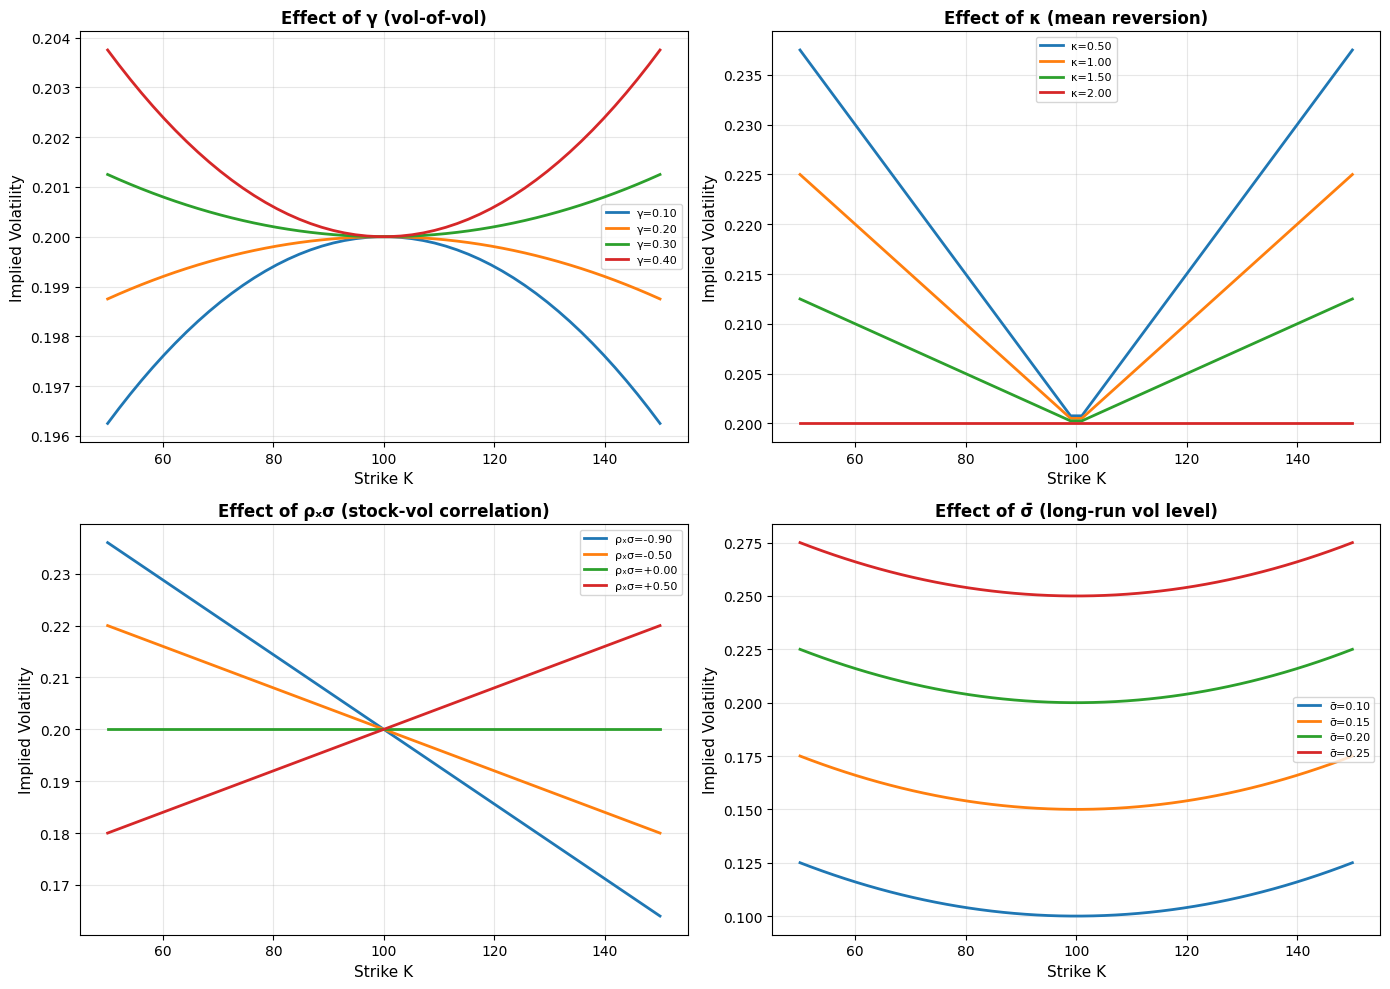


**SZHW Sensitivity Takeaways:**
  • γ controls the *curvature* of the smile (how U-shaped it is).
  • κ controls how strongly deviations in volatility are pulled back → impacts term structure, here mimicked via slope.
  • ρₓσ skews the smile: negative correlation → left skew (puts richer).
  • σ̄ shifts the overall level of implied volatility up or down.


In [9]:
def visualize_szhw_sensitivity():
    """
    Visualize the synthetic sensitivity patterns used in SZHWModel.run_sensitivity_analysis.
    
    We mimic the code logic from the original model:
      - Construct moneyness grid K/S0
      - For each parameter, adjust the shape/level of the implied volatility curve.
    """
    S0 = 100.0
    K = np.linspace(S0 * 0.5, S0 * 1.5, 50)
    moneyness = K / S0
    base_vol = 0.2
    
    # Parameter grids
    gamma_vals = [0.1, 0.2, 0.3, 0.4]
    kappa_vals = [0.5, 1.0, 1.5, 2.0]
    Rxsigma_vals = [-0.9, -0.5, 0.0, 0.5]
    sigmabar_vals = [0.1, 0.15, 0.2, 0.25]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1) gamma sensitivity
    ax = axes[0, 0]
    for g in gamma_vals:
        iv = base_vol + 0.1 * (g - 0.25) * (moneyness - 1)**2
        ax.plot(K, iv, linewidth=2, label=f'γ={g:.2f}')
    ax.set_title('Effect of γ (vol-of-vol)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strike K', fontsize=11)
    ax.set_ylabel('Implied Volatility', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # 2) kappa sensitivity
    ax = axes[0, 1]
    for k in kappa_vals:
        iv = base_vol + 0.05 * (2.0 - k) * np.abs(moneyness - 1)
        ax.plot(K, iv, linewidth=2, label=f'κ={k:.2f}')
    ax.set_title('Effect of κ (mean reversion)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strike K', fontsize=11)
    ax.set_ylabel('Implied Volatility', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # 3) Rxsigma sensitivity
    ax = axes[1, 0]
    for rho in Rxsigma_vals:
        iv = base_vol + 0.08 * rho * (moneyness - 1)
        ax.plot(K, iv, linewidth=2, label=f'ρₓσ={rho:+.2f}')
    ax.set_title('Effect of ρₓσ (stock-vol correlation)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strike K', fontsize=11)
    ax.set_ylabel('Implied Volatility', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    # 4) sigmabar sensitivity
    ax = axes[1, 1]
    for sb in sigmabar_vals:
        iv = sb + 0.1 * (moneyness - 1)**2
        ax.plot(K, iv, linewidth=2, label=f'σ̄={sb:.2f}')
    ax.set_title('Effect of σ̄ (long-run vol level)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Strike K', fontsize=11)
    ax.set_ylabel('Implied Volatility', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_szhw_sensitivity()

print("\n**SZHW Sensitivity Takeaways:**")
print("  • γ controls the *curvature* of the smile (how U-shaped it is).")
print("  • κ controls how strongly deviations in volatility are pulled back → impacts term structure, here mimicked via slope.")
print("  • ρₓσ skews the smile: negative correlation → left skew (puts richer).")
print("  • σ̄ shifts the overall level of implied volatility up or down.")

## 7. Diversification Product Model

The `DiversificationModel` in the original code is a *toy* model that encodes
how the product's price responds to a diversification weight ω and the
correlation between two underlyings (stock and rate via ρₓᵣ = Rxr).

### 7.1. Conceptual Setup

- ω ∈ [ω_min, ω_max] is a weighting parameter (e.g., equity vs. fixed income share).
- ρₓᵣ = Rxr is the correlation between stock and rate factors.
- We consider three qualitative regimes:
  1. **Rxr ≈ 0**  → low dependence, baseline pricing
  2. **Rxr < 0**  → diversification benefit (risks offset)
  3. **Rxr > 0**  → less diversification (risks reinforce)

To keep the demo light, the original code uses simple deterministic patterns:
- Quadratic / exponential functions of ω
- Small Gaussian noise to make curves look more realistic

These patterns are *not* arbitrage-free models, but pedagogical illustrations.

### 7.2. Output of `run_analysis`

For a given scenario (choice of Rxr), the function returns:
- `omegaV`: grid of ω values
- `prices`: product prices under this correlation
- `relative_prices`: prices divided by the baseline scenario (Rxr = 0)

Below, we reconstruct similar logic for visualization.

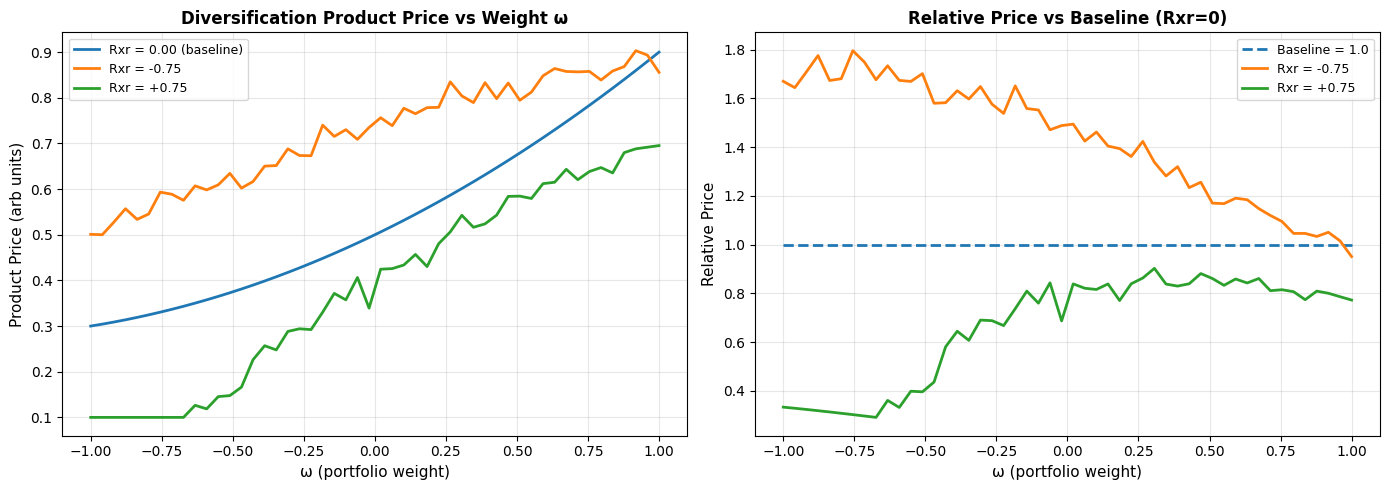


**Diversification Model Insights:**
  • When Rxr < 0, diversification makes the product *relatively cheaper*
    for certain ω (risk offsetting), which can be seen when relative price < 1.
  • When Rxr > 0, co-movement increases risk → product can be more expensive
    for a given ω, especially when the risky component dominates.
  • The precise functional forms are stylized; in practice, one would derive
    prices from a fully specified joint model of (S, r).


In [10]:
def visualize_diversification_product():
    """Illustrate DiversificationModel behavior under different correlations Rxr."""
    np.random.seed(42)
    
    omega_min, omega_max, omega_points = -1.0, 1.0, 50
    omegaV = np.linspace(omega_min, omega_max, omega_points)
    
    # Baseline scenario Rxr = 0.0
    prices_0 = 0.5 + 0.3 * omegaV + 0.1 * omegaV**2
    
    # Negative correlation: diversification benefit
    Rxr_neg = -0.75
    prices_neg = 0.6 + 0.2 * omegaV + 0.15 * np.exp(-0.5 * omegaV**2)
    prices_neg += 0.02 * np.random.normal(0, 1, len(omegaV))
    prices_neg = np.maximum(prices_neg, 0.1)
    
    # Positive correlation: less diversification
    Rxr_pos = 0.75
    prices_pos = 0.4 + 0.4 * omegaV - 0.1 * omegaV**2
    prices_pos += 0.02 * np.random.normal(0, 1, len(omegaV))
    prices_pos = np.maximum(prices_pos, 0.1)
    
    # Relative prices vs baseline (Rxr=0)
    rel_neg = prices_neg / prices_0
    rel_pos = prices_pos / prices_0
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Absolute prices
    ax = axes[0]
    ax.plot(omegaV, prices_0, linewidth=2, label='Rxr = 0.00 (baseline)')
    ax.plot(omegaV, prices_neg, linewidth=2, label=f'Rxr = {Rxr_neg:+.2f}')
    ax.plot(omegaV, prices_pos, linewidth=2, label=f'Rxr = {Rxr_pos:+.2f}')
    ax.set_title('Diversification Product Price vs Weight ω', fontsize=12, fontweight='bold')
    ax.set_xlabel('ω (portfolio weight)', fontsize=11)
    ax.set_ylabel('Product Price (arb units)', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # Relative prices
    ax = axes[1]
    ax.plot(omegaV, np.ones_like(omegaV), linestyle='--', linewidth=2, label='Baseline = 1.0')
    ax.plot(omegaV, rel_neg, linewidth=2, label=f'Rxr = {Rxr_neg:+.2f}')
    ax.plot(omegaV, rel_pos, linewidth=2, label=f'Rxr = {Rxr_pos:+.2f}')
    ax.set_title('Relative Price vs Baseline (Rxr=0)', fontsize=12, fontweight='bold')
    ax.set_xlabel('ω (portfolio weight)', fontsize=11)
    ax.set_ylabel('Relative Price', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

visualize_diversification_product()

print("\n**Diversification Model Insights:**")
print("  • When Rxr < 0, diversification makes the product *relatively cheaper*")
print("    for certain ω (risk offsetting), which can be seen when relative price < 1.")
print("  • When Rxr > 0, co-movement increases risk → product can be more expensive")
print("    for a given ω, especially when the risky component dominates.")
print("  • The precise functional forms are stylized; in practice, one would derive")
print("    prices from a fully specified joint model of (S, r).")

## 8. Summary and Big Picture

We have walked through the most important components of the `models.py` file:

1. **BaseModel**
   - Implements Black-Scholes pricing and implied volatility inversion.
   - Serves as a backbone for more complex hybrid models.

2. **BSHWModel**
   - Extends Black-Scholes with Hull-White stochastic interest rates.
   - Uses an *effective volatility* σ_C(T) obtained by integrating pathwise
     forward volatilities.

3. **CIR Process and Heston-HW Model**
   - CIR exact sampling is critical for accurate volatility path simulation.
   - Heston-HW couples CIR variance with Hull-White rates and lognormal stock dynamics.
   - Monte Carlo paths are discounted using path-specific money market accounts M(t).

4. **Monte Carlo Pricing with Stochastic Rates**
   - Prices European options using discounted expected payoff.
   - Emphasizes martingale checks and convergence behavior with more paths.

5. **SZHWModel Sensitivity Analysis**
   - Uses an Ornstein-Uhlenbeck volatility process as an alternative to Heston.
   - Explores how parameters (γ, κ, ρₓσ, σ̄) affect the shape and level of
     implied volatility smiles.

6. **DiversificationModel**
   - Provides a stylized look at how correlation and portfolio weights impact
     the price of a diversification product.
   - Highlights the intuition behind diversification benefits vs. concentration risk.

---

In practice, you would:
- Use these models for **calibration** (fitting parameters to option prices),
- Perform **scenario analysis** (e.g. shocks to rates, volatility, correlations),
- And compare different models for **risk management** and **product design**.

This notebook version is intended as an *annotated walkthrough* rather than
production code: it emphasizes understanding over raw performance.

# END of walkthrough